In [1]:
import functools
import numpy as np
import matplotlib.pyplot as plt
import keras
import keras.backend as K

/home/marco/.virtualenvs/ml/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
(xtrain, ytrain), (xtest, ytest) = keras.datasets.mnist.load_data()
xtrain, xtest = (x[:,:,:,np.newaxis]/255 for x in (xtrain, xtest))

In [3]:
X = X_input = keras.layers.Input((28,28,1))
X = keras.layers.Flatten()(X)
X = keras.layers.Dense(10, activation='softmax')(X)
M = keras.Model(X_input, X)
M.compile('adam', 'sparse_categorical_crossentropy', ['acc'])
M.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [4]:
M.fit(xtrain, ytrain, validation_data=(xtest, ytest), batch_size=64, epochs=5, callbacks=[
    keras.callbacks.ReduceLROnPlateau(patience=2, verbose=1)
])

Train on 60000 samples, validate on 10000 samples
Epoch 1/5
60000/60000 [==============================] - 3s 44us/step - loss: 0.5584 - acc: 0.8575 - val_loss: 0.3400 - val_acc: 0.9082
Epoch 2/5
60000/60000 [==============================] - 2s 34us/step - loss: 0.3252 - acc: 0.9101 - val_loss: 0.2938 - val_acc: 0.9202
Epoch 3/5
60000/60000 [==============================] - 2s 35us/step - loss: 0.2960 - acc: 0.9182 - val_loss: 0.2815 - val_acc: 0.9222
Epoch 4/5
60000/60000 [==============================] - 2s 35us/step - loss: 0.2823 - acc: 0.9205 - val_loss: 0.2735 - val_acc: 0.9243
Epoch 5/5
60000/60000 [==============================] - 2s 35us/step - loss: 0.2736 - acc: 0.9235 - val_loss: 0.2700 - val_acc: 0.9247


In [5]:
@functools.lru_cache()
def get_grad_curv(i):
    print(f'generating grad model of digit {i}')
    X = M(X_input)
    X = %time keras.layers.Lambda( \
        lambda x,i: K.gradients(x[1][:,i], x[0])[0], \
        output_shape=(28,28,1), \
        arguments={'i':i})([X_input, X])
    G = keras.Model(X_input, X)
    G.compile('adam', 'mse')
    print(f'generating curv model of digit {i}')
    X = G(X_input)
    def compute_hessian(x):
        return K.reshape(K.stack([
            K.gradients(x[1][:,iy,ix,:], x[0])[0]
            for iy in range(28)
            for ix in range(28)
        ], axis=1), (-1,28,28,1,28,28,1))
    def compute_curv(x):
        h = compute_hessian(x)
        return K.reshape(K.stack([
            h[:,iy,ix,:,iy,ix,:]
            for iy in range(28)
            for ix in range(28)
        ], axis=1), (-1,28,28,1))
    X = %time keras.layers.Lambda( \
        compute_curv, output_shape=(28,28,1))([X_input, X])
    C = keras.Model(X_input, X)
    C.compile('adam', 'mse')
    return G,C

In [6]:
def test_plot(test_label, improve_as):
    G,C = get_grad_curv(improve_as)
    test_idx = np.random.choice(np.where(ytest == test_label)[0])
    test = xtest[test_idx:test_idx+1]
    pred = M.predict(test)
    grad = G.predict(test)
    curv = C.predict(test)
    digit = np.argmax(pred[0])
    plt.figure(figsize=(15,5))
    plt.suptitle(f'labeled as {test_label}, predicted as {digit}, improve to be {improve_as}', fontsize=16)
    plt.subplot(1,3,1)
    plt.title('input')
    plt.imshow(test[0,:,:,0], cmap='jet')
    plt.colorbar()
    plt.subplot(1,3,2)
    plt.title('gradients')
    plt.imshow(grad[0,:,:,0], cmap='jet')
    plt.colorbar()
    plt.subplot(1,3,3)
    plt.title('curvatures')
    plt.imshow(curv[0,:,:,0], cmap='jet')
    plt.colorbar()
    plt.show()

generating grad model of digit 9
CPU times: user 10.3 ms, sys: 22 µs, total: 10.3 ms
Wall time: 10.1 ms
generating curv model of digit 9
CPU times: user 1min 4s, sys: 560 ms, total: 1min 5s
Wall time: 1min 4s


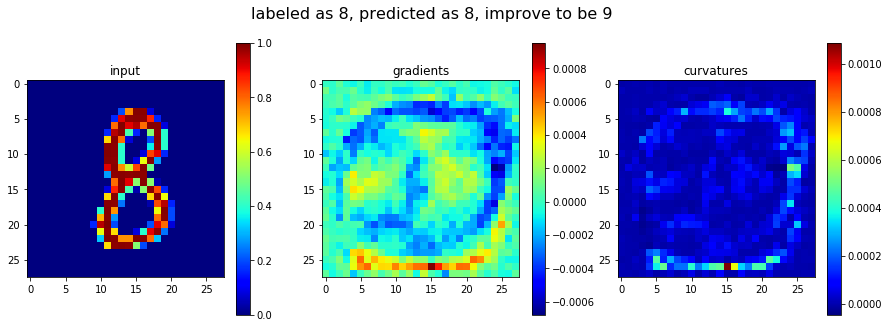

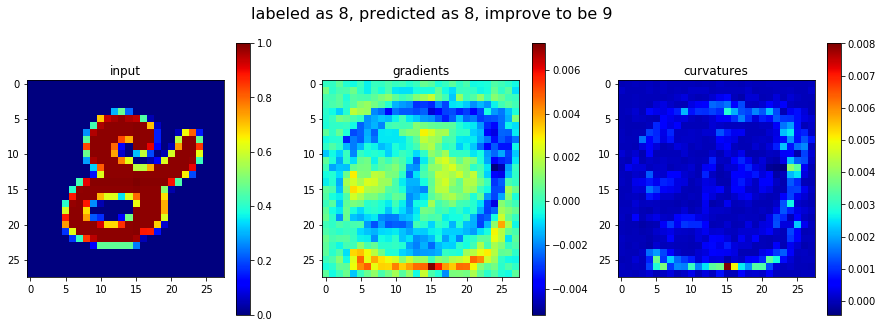

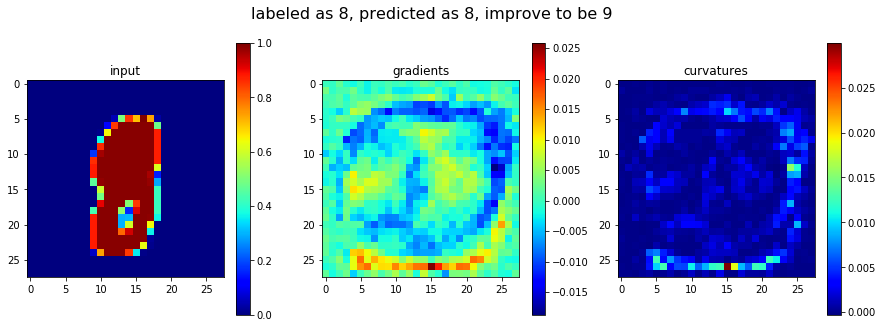

In [7]:
for _ in range(3):
    test_plot(8, 9)

generating grad model of digit 8
CPU times: user 119 ms, sys: 33.4 ms, total: 153 ms
Wall time: 111 ms
generating curv model of digit 8
CPU times: user 2min 28s, sys: 694 ms, total: 2min 29s
Wall time: 2min 28s


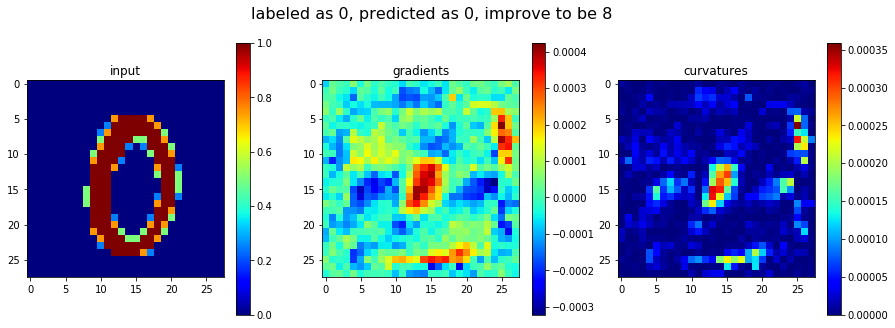

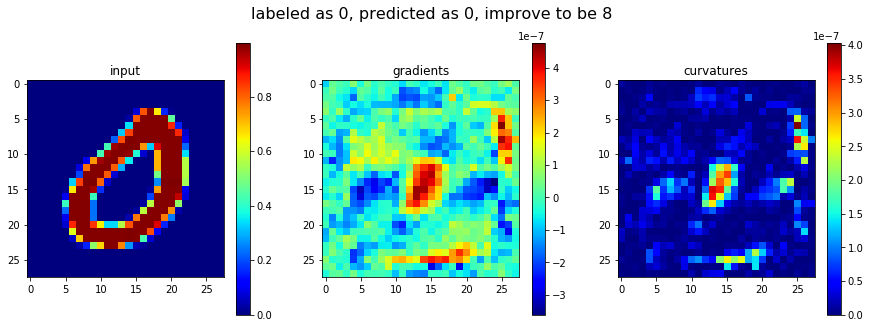

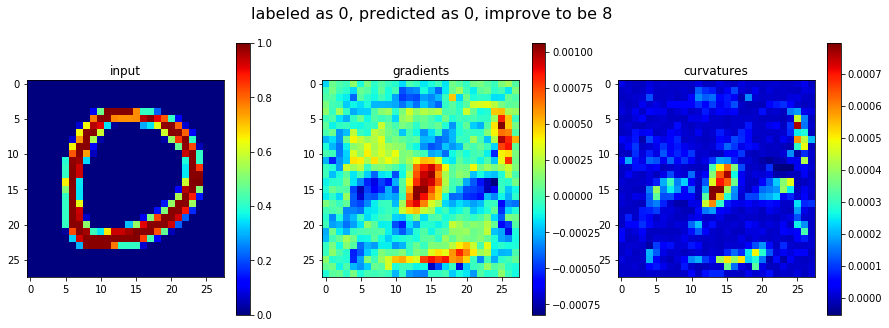

In [8]:
for _ in range(3):
    test_plot(0, 8)

generating grad model of digit 7
CPU times: user 238 ms, sys: 16.6 ms, total: 255 ms
Wall time: 239 ms
generating curv model of digit 7
CPU times: user 3min 50s, sys: 999 ms, total: 3min 51s
Wall time: 3min 50s


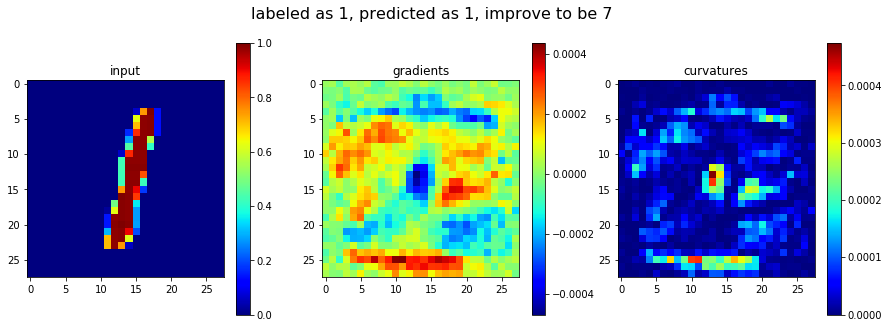

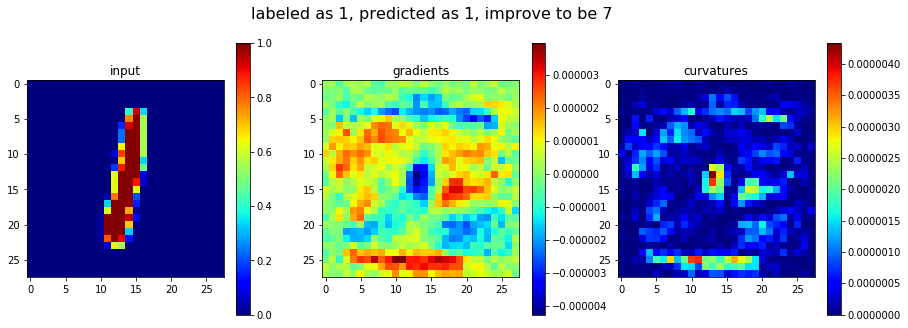

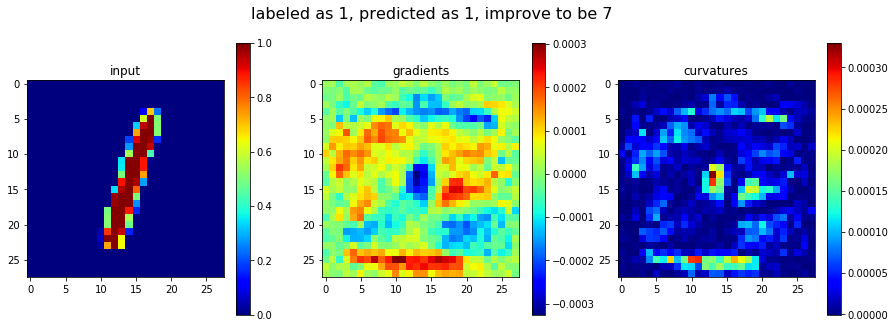

In [9]:
for _ in range(3):
    test_plot(1, 7)